In [28]:
# Import dependencies
import pandas as pd
import numpy as np
import zipfile
import glob
import shutil

In [29]:
# Assigned variables to the paths
zip_path = 'Resources/reviews_all.zip'
unzipped = 'Resources/unzip-reviews'

# Use zipfile to extract the archive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped)

In [30]:
# Assign the file names to a variable
review_files = ['reviews_0-250.csv','reviews_250-500.csv','reviews_500-750.csv','reviews_750-1250.csv','reviews_1250-end.csv']

# Use list comprehension to read the csv from the unzipped folder
df = [pd.read_csv(f'{unzipped}/{review_file}', low_memory=False) for review_file in review_files]
df = [pd.read_csv(file, low_memory=False) for file in glob.glob(f'{unzipped}/*.csv')]

In [31]:
# Concatenate dataframes
merged_df = pd.concat(df, ignore_index=True)

# Delete the unzipped folder to avoid pushing to github
shutil.rmtree(unzipped)

merged_df.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [32]:
# Merged on product id so the primary categories are assigned to each review, along with the ingredients if we decide to use them
product_info_df = pd.read_csv('Resources/product_info.csv', low_memory=False)

In [33]:
complete_df = pd.merge(merged_df, product_info_df[['product_id', 'secondary_category', 'ingredients']], on='product_id', how='left')

In [34]:
complete_df['submission_time'] = pd.to_datetime(complete_df['submission_time'], format='%Y-%m-%d')

In [35]:
columns = ['product_id', 'product_name', 'brand_name', 'price_usd', 'secondary_category', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'review_text', 'review_title', 'submission_time']
complete_df = complete_df[columns]
complete_df.head()

,product_id,product_name,brand_name,price_usd,secondary_category,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,review_text,review_title,submission_time
0,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,Cleansers,5,1.0,1.0,2,0,2,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,2023-02-01
1,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Balms & Treatments,1,0.0,NaN,0,0,0,I bought this lip mask after reading the revie...,Disappointed,2023-03-21
2,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Balms & Treatments,5,1.0,NaN,0,0,0,My review title says it all! I get so excited ...,New Favorite Routine,2023-03-21
3,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Balms & Treatments,5,1.0,NaN,0,0,0,I’ve always loved this formula for a long time...,Can't go wrong with any of them,2023-03-20
4,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Balms & Treatments,5,1.0,NaN,0,0,0,"If you have dry cracked lips, this is a must h...",A must have !!!,2023-03-20


In [36]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094411 entries, 0 to 1094410
Data columns (total 14 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   product_id                1094411 non-null  object        
 1   product_name              1094411 non-null  object        
 2   brand_name                1094411 non-null  object        
 3   price_usd                 1094411 non-null  float64       
 4   secondary_category        1094411 non-null  object        
 5   rating                    1094411 non-null  int64         
 6   is_recommended            926423 non-null   float64       
 7   helpfulness               532819 non-null   float64       
 8   total_feedback_count      1094411 non-null  int64         
 9   total_neg_feedback_count  1094411 non-null  int64         
 10  total_pos_feedback_count  1094411 non-null  int64         
 11  review_text               1092967 non-null  object

In [37]:
# Remove brands not related to the study
target_brands = ['Tatcha', 'The Ordinary', 'Dior', 'Estée Lauder', 'LANEIGE']

target_brands_df = complete_df[complete_df['brand_name'].isin(target_brands)]
count_by_target_brand = target_brands_df['brand_name'].value_counts()
count_by_target_brand

brand_name
Tatcha          46770
The Ordinary    35934
LANEIGE         27519
Estée Lauder    17341
Dior             6150
Name: count, dtype: int64

In [38]:
product = target_brands_df[target_brands_df['product_id'] == 'P417604']
product

,product_id,product_name,brand_name,price_usd,secondary_category,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,review_text,review_title,submission_time
644494,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,4,0.0,1.000000,2,0,2,Is it worth the price? I don’t think so consid...,NaN,2022-02-24
644495,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,5,1.0,0.500000,2,1,1,As a swimmer during COVID times when we need t...,Great for splashing on after swim,2021-10-02
644496,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,4,1.0,0.500000,2,1,1,"It did the job, hydrate my skin. I did not fa...",Fine but now wow,2020-12-19
644497,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,3,1.0,0.500000,8,4,4,"The product is mediocre, the bottle design is ...",Finishing bottle but not buying again.,2020-08-20
644498,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,5,1.0,1.000000,11,0,11,I bought the whole LIFE collection... sadly I ...,dior is the best!,2020-08-17
644499,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,5,1.0,0.888889,9,1,8,I love the feeling of this serum on my skin; i...,Works wonderfully and smell good.,2020-07-16
644500,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,5,1.0,0.666667,6,2,4,I’ve been using this essence for years and lov...,Love this essence,2020-04-12
644501,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,1,0.0,0.400000,5,3,2,I really didn’t feel this did anything for my ...,NaN,2020-03-08
644502,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,5,1.0,0.538462,13,6,7,"Many years ago, I had a lot of dryness on my s...",repairs skin,2019-09-08
644503,P417604,Hydra Life Deep Hydration Sorbet Water Essence,Dior,80.0,Treatments,2,0.0,0.625000,8,3,5,I’m a huge fan of Dior skincare. I use their C...,NaN,2019-07-07


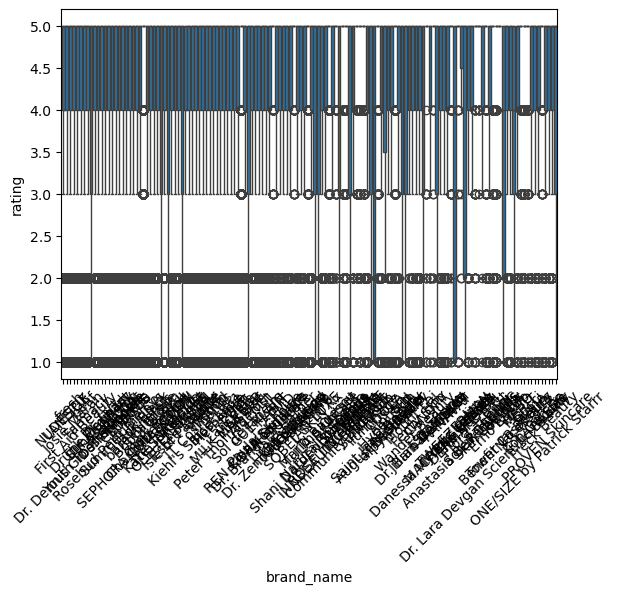

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='brand_name', y='rating', data=complete_df)
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='brand_name'>

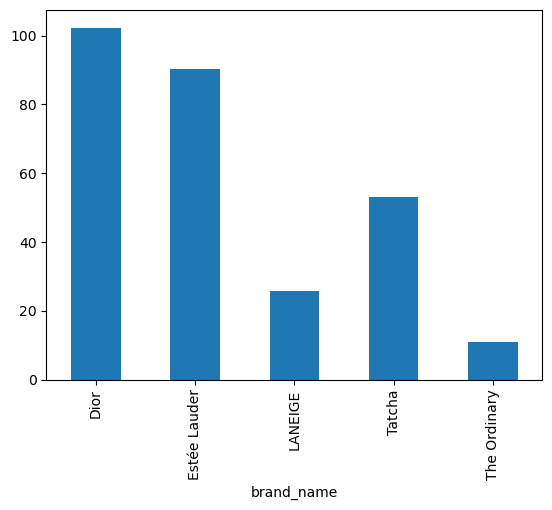

In [40]:
avg_price_per_brand = target_brands_df.groupby('brand_name')['price_usd'].mean()
avg_price_per_brand.plot(kind='bar')

<Axes: xlabel='product_name'>

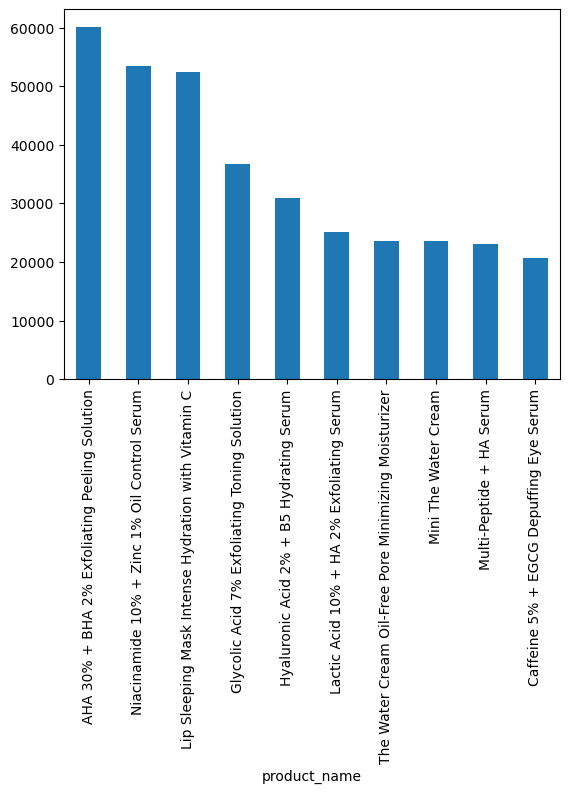

In [41]:
top_products = target_brands_df.groupby('product_name')['total_feedback_count'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar')

<Axes: xlabel='brand_name'>

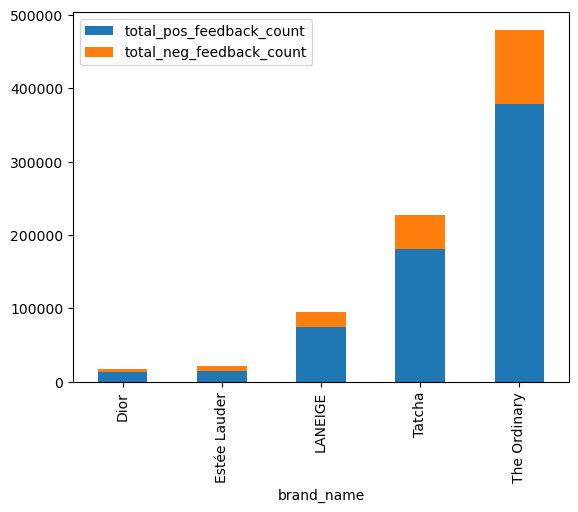

In [42]:
target_brands_df.groupby('brand_name')[['total_pos_feedback_count', 'total_neg_feedback_count']].sum().plot(kind='bar', stacked=True)

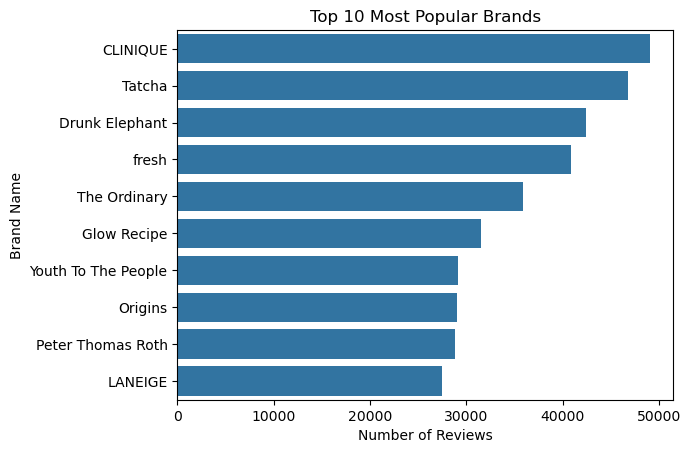

In [43]:
brand_popularity = complete_df['brand_name'].value_counts().head(10)
sns.barplot(x=brand_popularity.values, y=brand_popularity.index)
plt.xlabel('Number of Reviews')
plt.ylabel('Brand Name')
plt.title('Top 10 Most Popular Brands')
plt.show()

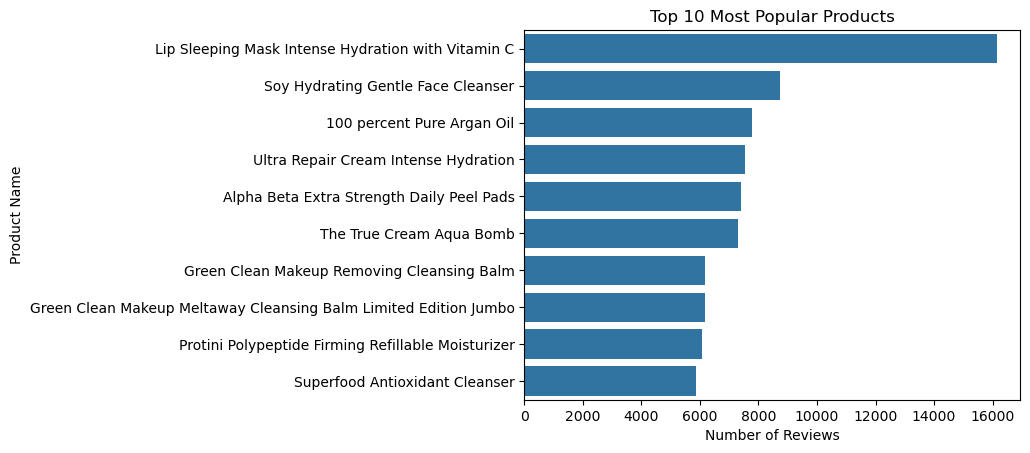

In [44]:
product_popularity = complete_df['product_name'].value_counts().head(10)
sns.barplot(x=product_popularity.values, y=product_popularity.index)
plt.xlabel('Number of Reviews')
plt.ylabel('Product Name')
plt.title('Top 10 Most Popular Products')
plt.show()

In [45]:
## This adds a new row that puts the brand name after the product name for display purposes,
## but also adds it to the dataframe, so don't run the last cell to output to csv if you run this cell
# complete_df['product_with_brand'] = complete_df['product_name'] + ' (' + complete_df['brand_name'] + ')'

# product_popularity = complete_df['product_with_brand'].value_counts().head(10)
# sns.barplot(x=product_popularity.values, y=product_popularity.index)
# plt.xlabel('Number of Reviews')
# plt.ylabel('Product (Brand)')
# plt.title('Top 10 Most Popular Products (with Brand Names)')
# plt.show()


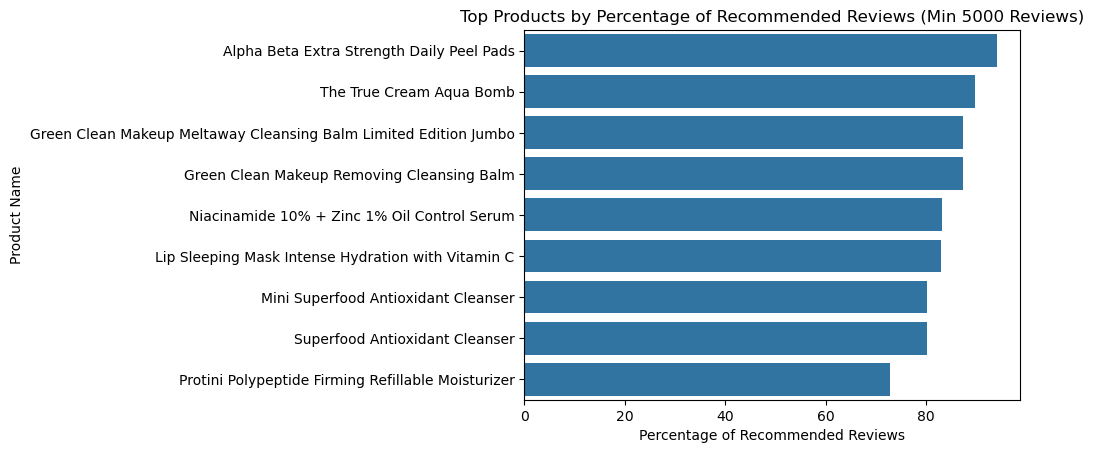

In [46]:
product_stats = complete_df.groupby('product_name').agg(
    total_reviews=pd.NamedAgg(column='is_recommended', aggfunc='count'),
    recommended_sum=pd.NamedAgg(column='is_recommended', aggfunc='sum'))
product_stats['recommended_percentage'] = (product_stats['recommended_sum'] / product_stats['total_reviews']) * 100
threshold = 5000
filtered_products = product_stats[product_stats['total_reviews'] >= threshold]
top_products = filtered_products.sort_values('recommended_percentage', ascending=False).head(20)
sns.barplot(x=top_products['recommended_percentage'], y=top_products.index)
plt.xlabel('Percentage of Recommended Reviews')
plt.ylabel('Product Name')
plt.title('Top Products by Percentage of Recommended Reviews (Min ' + str(threshold) + ' Reviews)')
plt.show()


In [47]:
complete_df['helpfulness'].value_counts().head(35)

helpfulness
1.000000    251334
0.000000     47741
0.500000     34987
0.666667     24887
0.750000     18160
0.800000     13604
0.833333     10324
0.333333      8465
0.857143      8213
0.875000      6327
0.600000      6022
0.888889      5057
0.900000      4094
0.714286      4005
0.250000      3226
0.909091      3099
0.400000      2940
0.777778      2716
0.916667      2680
0.571429      2308
0.923077      2151
0.625000      2009
0.818182      1868
0.928571      1719
0.200000      1527
0.933333      1481
0.428571      1321
0.700000      1304
0.846154      1294
0.937500      1257
0.727273      1223
0.941176      1066
0.555556      1026
0.866667       938
0.166667       924
Name: count, dtype: int64

In [48]:
# Don't push this file to the repository, it's too large
# This is for the postgreSQL database and must be done from a local repository
# Uncomment this if you want to save it for yourself
# complete_df.to_csv('Resources/complete_df.csv', index=False, encoding='utf=8')


In [49]:
# JSON File conversion (Run this to get the JSON File, Keep on Local and do not push to repository)
# Too large for our purposes and cannot load on html. Uncomment this if you want to save it for yourself
# complete_df.to_json('Resources/complete_json.json', orient='records')

In [64]:
# Smaller subset that queries entries from 2022-03-01 to 2023-03
oneyear_df = complete_df[complete_df['submission_time'] >= pd.Timestamp('2022-03-01')]
oneyear_df.to_json('Resources/oneyear_df.json', orient='records')

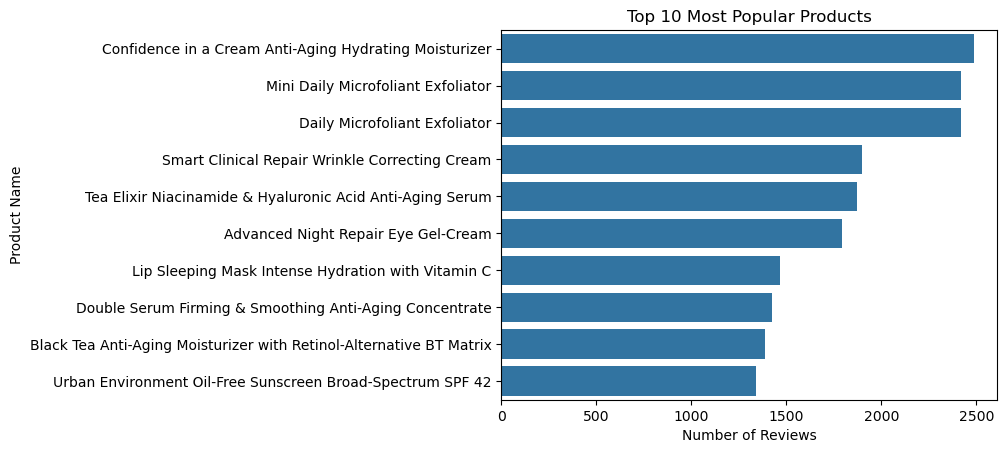

In [66]:
product_popularity = oneyear_df['product_name'].value_counts().head(10)
sns.barplot(x=product_popularity.values, y=product_popularity.index)
plt.xlabel('Number of Reviews')
plt.ylabel('Product Name')
plt.title('Top 10 Most Popular Products')
plt.show()

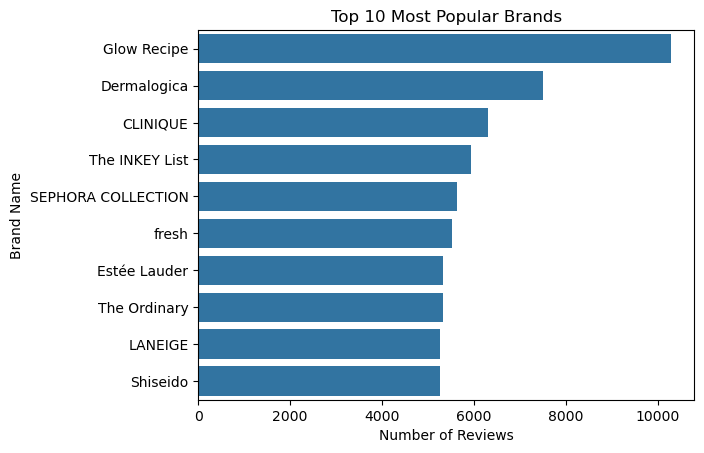

In [67]:
brand_popularity = oneyear_df['brand_name'].value_counts().head(10)
sns.barplot(x=brand_popularity.values, y=brand_popularity.index)
plt.xlabel('Number of Reviews')
plt.ylabel('Brand Name')
plt.title('Top 10 Most Popular Brands')
plt.show()